merge instructions: https://stackoverflow.com/questions/43297589/merge-two-data-frames-based-on-common-column-values-in-pandas


In [2]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns    
import scipy                                     



In [3]:
gse = GEOparse.get_GEO("GSE4271", destdir="data/",silent=True)

In [4]:

    
    
gsm = list(gse.gsms.values())[0]
print("\nData processing info:", gsm.metadata.get("data_processing", ["N/A"]), "(already normalized)")


Data processing info: ['Affymetrix Microarray Suite Version 5.0'] (already normalized)


In [ ]:

expression_dict = {}

for gsm_name, gsm in gse.gsms.items():
    expression_dict[gsm_name] = gsm.table.set_index('ID_REF')['VALUE'] # Map probe IDs (e.g., 1007_s_at) to gene symbols

expression_df = pd.DataFrame(expression_dict)

# normalization

expression_df = np.log2(expression_df)

expression_df.to_csv('data/GSE4271_expression_data.csv') # Save the expression data to a CSV file


In [6]:

meta = []
for gsm_name, gsm in gse.gsms.items():
    characteristics = gsm.metadata.get('characteristics_ch1', [])
    char_dict = {}
    for entry in characteristics:
        if ":" in entry:
            key, value = entry.split(":", 1)
            char_dict[key.strip()] = value.strip()   
    char_dict["sample"] = gsm_name
    char_dict["title"] = gsm.metadata.get("title", [""])[0]
    char_dict["source_name"] = gsm.metadata.get("source_name_ch1", [""])[0]
    meta.append(char_dict)
    
    
meta_df = pd.DataFrame(meta).set_index('sample')

# Getting indexes of primary and recurrent samples from metadata

primary_samples = meta_df[meta_df['specimen type'] == 'primary'].index
recurrent_samples = meta_df[meta_df['specimen type'] == 'recurrent'].index

# Split expression data into primary and recurrent

primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]

mean_expression_primary = primary_expression.mean(axis=1)
mean_expression_recurrent = recurrent_expression.mean(axis=1)
mean_expression_df = pd.DataFrame({
    'Primary': mean_expression_primary,
    'Recurrent': mean_expression_recurrent
})

print(mean_expression_df)

                          Primary  Recurrent
ID_REF                                      
1007_s_at               12.220410  12.107889
1053_at                  8.266981   8.596912
117_at                   7.453475   7.349202
121_at                   9.876914   9.819171
1255_g_at                6.017399   5.758419
...                           ...        ...
AFFX-r2-Hs28SrRNA-3_at   9.946813   9.808588
AFFX-r2-Hs28SrRNA-5_at   7.254966   6.922945
AFFX-r2-Hs28SrRNA-M_at   8.231477   8.143051
AFFX-r2-P1-cre-3_at     14.938020  14.784824
AFFX-r2-P1-cre-5_at     14.631455  14.488055

[44760 rows x 2 columns]


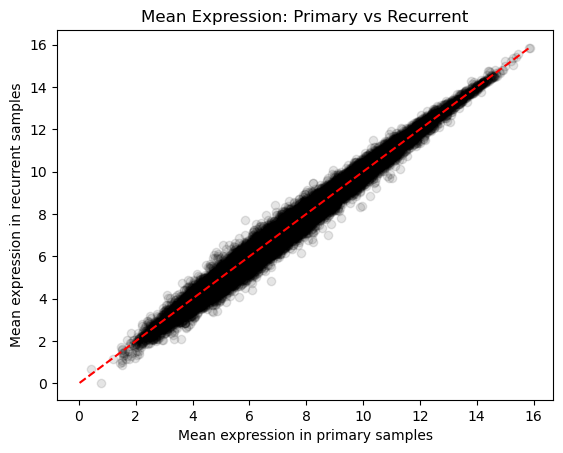

In [7]:
#Scatter plot

plt.scatter(mean_expression_df['Primary'], mean_expression_df['Recurrent'], c='k', alpha=0.1)
plt.xlabel("Mean expression in primary samples")
plt.ylabel("Mean expression in recurrent samples")
plt.title("Mean Expression: Primary vs Recurrent")
plt.plot([mean_expression_df.min().min(), mean_expression_df.max().max()], [mean_expression_df.min().min(), mean_expression_df.max().max()], 'r--')
plt.show()

In [ ]:
#Prep data for volcano plot
 

log2_fc = mean_expression_df['Recurrent'] - mean_expression_df['Primary'] #Log 2 fold change
p_values = []


#Use t-test when comparing 2 means
for gene in expression_df.index:
    stat, p = scipy.stats.ttest_ind(recurrent_expression.loc[gene], primary_expression.loc[gene], equal_var=False)
    p_values.append(p)


results_df = pd.DataFrame({"log2_fc": log2_fc, 'p_value': p_values},index =expression_df.index)
results_df['minus_log_p'] = -np.log10(results_df['p_value'])

#Label significant genes (If there is any)
results_df["Significant"] = np.where((results_df['p_value'] < 0.05),"Yes","No")




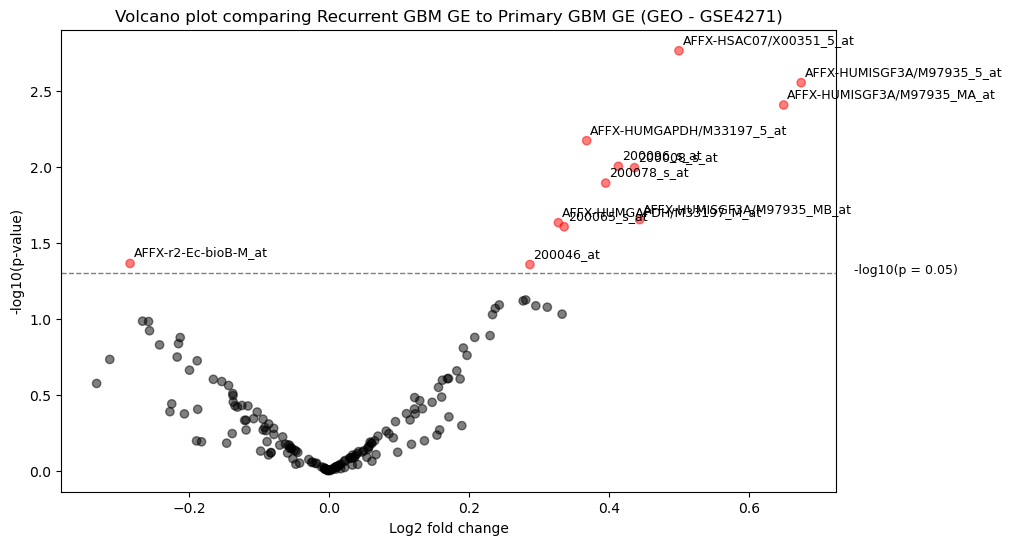

In [56]:
# Volcano plot

significants = results_df[(results_df["Significant"] == "Yes")][["log2_fc","minus_log_p"]]

plt.figure(figsize=(10, 6))

colors = np.where(results_df["Significant"] == "Yes","red","black")

plt.scatter(results_df["log2_fc"], results_df["minus_log_p"], c=colors, alpha=0.5)



plt.xlabel("Log2 fold change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano plot comparing Recurrent GBM GE to Primary GBM GE (GEO - GSE4271)")

y_thresh = -np.log10(0.05)
plt.axhline(y=y_thresh, color='gray', linestyle='--', linewidth=1)
ax = plt.gca()
ax.text(0.75, y_thresh, "-log10(p = 0.05)",
        color='k', fontsize=9)

for gene,x,y in zip(significants.index,significants["log2_fc"], significants["minus_log_p"]):
        ax.text(x+0.005,y+0.05,gene,fontsize =9)

plt.show()



Higher y = More significant;To the left = Downregulate (Recurrent compared to Primary); To the right = Upregulated (Recurrent compared to Primary)